# TMDB Movie Data Analysis

In [193]:
import numpy as np
import pandas as pd
import seaborn as sns
import ast, json
import networkx as nx
from collections import Counter
from wordcloud import WordCloud

# Stemming
import nltk
from nltk.stem import PorterStemmer

# BOW
from sklearn.feature_extraction.text import CountVectorizer

#
from sklearn.metrics.pairwise import cosine_similarity

from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

### Load the data

In [194]:
credits_df = pd.read_csv('data/tmdb_5000_credits.csv')
movies_df = pd.read_csv('data/tmdb_5000_movies.csv')
movies_df.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [195]:
credits_df.shape

(4803, 4)

In [196]:
movies_df.shape

(4803, 20)

In [197]:
# merging the two files
movies_df = pd.merge(movies_df, credits_df, on= 'title')
movies_df.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [198]:
movies_df.shape

(4809, 23)

### Data Cleaning Process

>After observing the dataset and proposed questions for the analysis we will be keeping only relevent data deleting the unsued data so that we can make our calculation easy and understandable. .

> Steps to be taken to clean the data.
1. We need to remove unused column such as id, imdb_id, vote_count, production_company, keywords, homepage etc.
2. Removing the duplicacy in the rows(if any).
3. Some movies in the database have zero budget or zero revenue, that is there value has not been recorded so we will be discarding such entries.
4. Changing release date column into date format.
5. Replacing zero with NAN in runtime column.
6. Changing format of budget and revenue column.



In [199]:
# keep atriibute neccescary
movies_df = movies_df[['movie_id','title','overview','genres','keywords','cast','crew', 'release_date', 'runtime', 'vote_average', 'vote_count']]

In [200]:
movies_df.duplicated().sum()

0

In [201]:
movies_df.head()

,movie_id,title,overview,genres,keywords,cast,crew,release_date,runtime,vote_average,vote_count
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",2009-12-10,162.0,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",2007-05-19,169.0,6.9,4500
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",2015-10-26,148.0,6.3,4466
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",2012-07-16,165.0,7.6,9106
4,49529,John Carter,"John Carter is a war-weary, former military ca...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",2012-03-07,132.0,6.1,2124


In [202]:
movies_df.isnull().sum()

movie_id        0
title           0
overview        3
genres          0
keywords        0
cast            0
crew            0
release_date    1
runtime         2
vote_average    0
vote_count      0
dtype: int64

In [203]:
#  dropping the nan from the dataset.
movies_df.dropna(inplace=True)

In [204]:
#  dropping the duplicates from the dataset.
print(movies_df.shape)
movies_df = movies_df.drop_duplicates(keep='first')
print(movies_df.shape)

(4805, 11)
(4805, 11)


In [205]:
# handle genres
movies_df.iloc[0]['genres']

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [206]:
def convert(text):
    L = []
    for i in ast.literal_eval(text):
        L.append(i['name']) 
    return L
movies_df['genres'] = movies_df['genres'].apply(convert)
movies_df['keywords'] = movies_df['keywords'].apply(convert)

In [207]:
movies_df.head()

,movie_id,title,overview,genres,keywords,cast,crew,release_date,runtime,vote_average,vote_count
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",2009-12-10,162.0,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",2007-05-19,169.0,6.9,4500
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",2015-10-26,148.0,6.3,4466
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",2012-07-16,165.0,7.6,9106
4,49529,John Carter,"John Carter is a war-weary, former military ca...","[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",2012-03-07,132.0,6.1,2124


In [208]:
# handle cast
def convert_cast(text):
    L = []
    counter = 0
    for i in ast.literal_eval(text):
        if counter < 3:
            L.append(i['name'])
        counter+=1
    return L
movies_df['cast'] = movies_df['cast'].apply(convert_cast)
movies_df.head()

,movie_id,title,overview,genres,keywords,cast,crew,release_date,runtime,vote_average,vote_count
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",2009-12-10,162.0,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",2007-05-19,169.0,6.9,4500
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Daniel Craig, Christoph Waltz, Léa Seydoux]","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",2015-10-26,148.0,6.3,4466
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...","[Christian Bale, Michael Caine, Gary Oldman]","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",2012-07-16,165.0,7.6,9106
4,49529,John Carter,"John Carter is a war-weary, former military ca...","[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...","[Taylor Kitsch, Lynn Collins, Samantha Morton]","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",2012-03-07,132.0,6.1,2124


In [209]:
# handle crew
def fetch_director(text):
    L = []
    for i in ast.literal_eval(text):
        if i['job'] == 'Director':
            L.append(i['name'])
            break
    return L
movies_df['crew'] = movies_df['crew'].apply(fetch_director)
movies_df.head()

,movie_id,title,overview,genres,keywords,cast,crew,release_date,runtime,vote_average,vote_count
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron],2009-12-10,162.0,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski],2007-05-19,169.0,6.9,4500
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Daniel Craig, Christoph Waltz, Léa Seydoux]",[Sam Mendes],2015-10-26,148.0,6.3,4466
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...","[Christian Bale, Michael Caine, Gary Oldman]",[Christopher Nolan],2012-07-16,165.0,7.6,9106
4,49529,John Carter,"John Carter is a war-weary, former military ca...","[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...","[Taylor Kitsch, Lynn Collins, Samantha Morton]",[Andrew Stanton],2012-03-07,132.0,6.1,2124


In [210]:
# handle overview (converting to list)
movies_df['overview'] = movies_df['overview'].apply(lambda x:x.split())
movies_df.sample(4)

,movie_id,title,overview,genres,keywords,cast,crew,release_date,runtime,vote_average,vote_count
3373,14578,Outside Providence,"[In, this, coming-of-age, comedy,, Tim, Dunphy...","[Romance, Comedy, Drama]","[suicide, sex, sexuality, college, police, cam...","[Shawn Hatosy, Amy Smart, Alec Baldwin]",[Michael Corrente],1999-08-16,96.0,5.6,30
4597,10238,Cries and Whispers,"[When, a, woman, dying, of, cancer, in, turn-o...",[Drama],"[sister sister relationship, sweden, dying and...","[Harriet Andersson, Ingrid Thulin, Kari Sylwan]",[Ingmar Bergman],1972-12-21,91.0,7.8,115
4228,4174,Spellbound,"[When, Dr., Anthony, Edwardes, arrives, at, a,...","[Drama, Mystery, Thriller]","[amnesia, insane asylum, suspense]","[Ingrid Bergman, Gregory Peck, Michael Chekhov]",[Alfred Hitchcock],1945-12-28,111.0,7.3,160
2906,50601,5 Days of War,"[An, American, journalist, and, his, cameraman...","[War, Drama]","[journalist, interpreter, georgia europe, war ...","[Rupert Friend, Val Kilmer, Andy García]",[Renny Harlin],2011-04-14,113.0,5.8,62


In [211]:
#removing space
def remove_space(L):
    L1 = []
    for i in L:
        L1.append(i.replace(" ",""))
    return L1

movies_df['cast'] = movies_df['cast'].apply(remove_space)
movies_df['crew'] = movies_df['crew'].apply(remove_space)
movies_df['genres'] = movies_df['genres'].apply(remove_space)
movies_df['keywords'] = movies_df['keywords'].apply(remove_space)

movies_df.head()

,movie_id,title,overview,genres,keywords,cast,crew,release_date,runtime,vote_average,vote_count
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron],2009-12-10,162.0,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...","[JohnnyDepp, OrlandoBloom, KeiraKnightley]",[GoreVerbinski],2007-05-19,169.0,6.9,4500
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, basedonnovel, secretagent, sequel, mi6, ...","[DanielCraig, ChristophWaltz, LéaSeydoux]",[SamMendes],2015-10-26,148.0,6.3,4466
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[Action, Crime, Drama, Thriller]","[dccomics, crimefighter, terrorist, secretiden...","[ChristianBale, MichaelCaine, GaryOldman]",[ChristopherNolan],2012-07-16,165.0,7.6,9106
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili...","[Action, Adventure, ScienceFiction]","[basedonnovel, mars, medallion, spacetravel, p...","[TaylorKitsch, LynnCollins, SamanthaMorton]",[AndrewStanton],2012-03-07,132.0,6.1,2124


In [212]:
movies_df['tags'] = movies_df['overview'] \
                    + movies_df['genres'] \
                    + movies_df['keywords'] \
                    + movies_df['cast'] \
                    + movies_df['crew'] 

In [213]:
movies_df.head()

,movie_id,title,overview,genres,keywords,cast,crew,release_date,runtime,vote_average,vote_count,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron],2009-12-10,162.0,7.2,11800,"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...","[JohnnyDepp, OrlandoBloom, KeiraKnightley]",[GoreVerbinski],2007-05-19,169.0,6.9,4500,"[Captain, Barbossa,, long, believed, to, be, d..."
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, basedonnovel, secretagent, sequel, mi6, ...","[DanielCraig, ChristophWaltz, LéaSeydoux]",[SamMendes],2015-10-26,148.0,6.3,4466,"[A, cryptic, message, from, Bond’s, past, send..."
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[Action, Crime, Drama, Thriller]","[dccomics, crimefighter, terrorist, secretiden...","[ChristianBale, MichaelCaine, GaryOldman]",[ChristopherNolan],2012-07-16,165.0,7.6,9106,"[Following, the, death, of, District, Attorney..."
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili...","[Action, Adventure, ScienceFiction]","[basedonnovel, mars, medallion, spacetravel, p...","[TaylorKitsch, LynnCollins, SamanthaMorton]",[AndrewStanton],2012-03-07,132.0,6.1,2124,"[John, Carter, is, a, war-weary,, former, mili..."


In [ ]:
# droping those extra columns
new_df = movies_df[['movie_id','title','tags']]
new_df.head()

In [ ]:
# Converting list to str
new_df['tags'] = new_df['tags'].apply(lambda x: " ".join(x))
new_df['tags'] = new_df['tags'].apply(lambda x:x.lower())
new_df.head()

,movie_id,title,overview,genres,keywords,cast,crew,release_date,runtime,vote_average,vote_count,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron],2009-12-10,162.0,7.2,11800,"in the 22nd century, a paraplegic marine is di..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...","[JohnnyDepp, OrlandoBloom, KeiraKnightley]",[GoreVerbinski],2007-05-19,169.0,6.9,4500,"captain barbossa, long believed to be dead, ha..."
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, basedonnovel, secretagent, sequel, mi6, ...","[DanielCraig, ChristophWaltz, LéaSeydoux]",[SamMendes],2015-10-26,148.0,6.3,4466,a cryptic message from bond’s past sends him o...
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[Action, Crime, Drama, Thriller]","[dccomics, crimefighter, terrorist, secretiden...","[ChristianBale, MichaelCaine, GaryOldman]",[ChristopherNolan],2012-07-16,165.0,7.6,9106,following the death of district attorney harve...
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili...","[Action, Adventure, ScienceFiction]","[basedonnovel, mars, medallion, spacetravel, p...","[TaylorKitsch, LynnCollins, SamanthaMorton]",[AndrewStanton],2012-03-07,132.0,6.1,2124,"john carter is a war-weary, former military ca..."


## Building Recomemdation system

### Stemming 

Stemming helps reduce words to their root form, improving search and recommendation accuracy.
We use PorterStemmer to transform words into their base form.

Stemming Formula: **stemmed_word = PorterStemmer(word)**


In [ ]:
ps = PorterStemmer()

def stems(text):
    T = []
    
    for i in text.split():
        T.append(ps.stem(i))
    
    return " ".join(T)
new_df['tags'] = new_df['tags'].apply(stems)

In [ ]:
new_df.head()

,movie_id,title,overview,genres,keywords,cast,crew,release_date,runtime,vote_average,vote_count,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron],2009-12-10,162.0,7.2,11800,"in the 22nd century, a parapleg marin is dispa..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...","[JohnnyDepp, OrlandoBloom, KeiraKnightley]",[GoreVerbinski],2007-05-19,169.0,6.9,4500,"captain barbossa, long believ to be dead, ha c..."
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, basedonnovel, secretagent, sequel, mi6, ...","[DanielCraig, ChristophWaltz, LéaSeydoux]",[SamMendes],2015-10-26,148.0,6.3,4466,a cryptic messag from bond’ past send him on a...
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[Action, Crime, Drama, Thriller]","[dccomics, crimefighter, terrorist, secretiden...","[ChristianBale, MichaelCaine, GaryOldman]",[ChristopherNolan],2012-07-16,165.0,7.6,9106,follow the death of district attorney harvey d...
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili...","[Action, Adventure, ScienceFiction]","[basedonnovel, mars, medallion, spacetravel, p...","[TaylorKitsch, LynnCollins, SamanthaMorton]",[AndrewStanton],2012-03-07,132.0,6.1,2124,"john carter is a war-weary, former militari ca..."


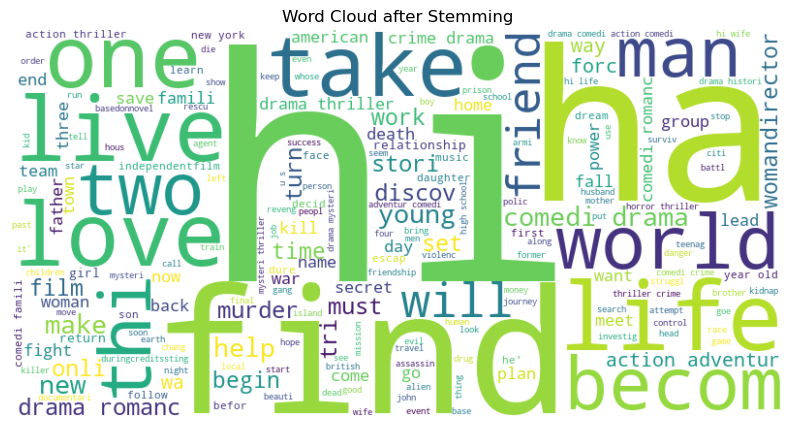

In [ ]:
text = " ".join(new_df['tags'])

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud after Stemming")
plt.show()

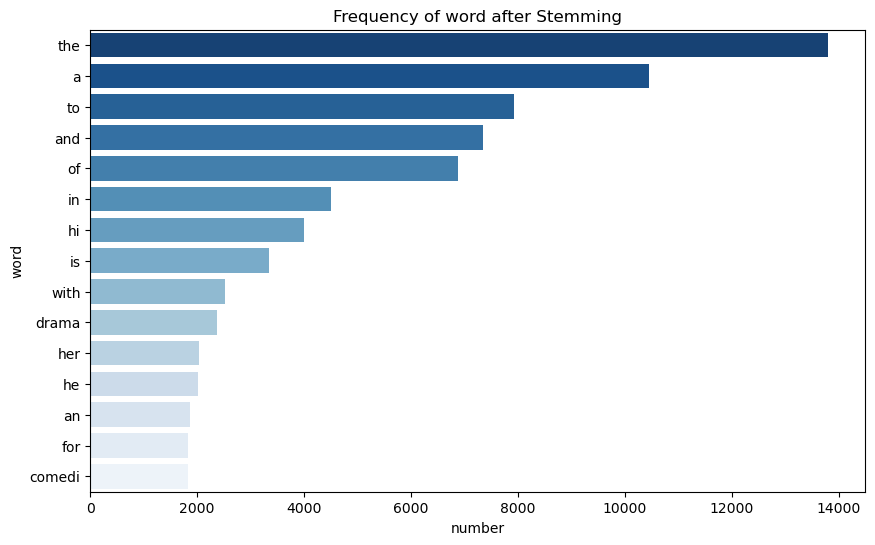

In [219]:
word_counts = Counter(text.split())

df_word_counts = pd.DataFrame(word_counts.most_common(15), columns=['Word', 'Count'])

plt.figure(figsize=(10, 6))
sns.barplot(x="Count", y="Word", data=df_word_counts, palette="Blues_r")
plt.xlabel("number")
plt.ylabel("word")
plt.title("Frequency of word after Stemming")
plt.show()

### Bag of Words (BoW)

BoW converts text into a numerical vector based on word occurrences in a document.
We use CountVectorizer to construct a feature matrix from the dataset.

In [220]:
cv = CountVectorizer(max_features=5000,stop_words='english')

In [ ]:
vector = cv.fit_transform(new_df['tags']).toarray()

### Cosine Similarity 

We use Cosine Similarity to measure how similar two movies are based on their content.:

$$
\cos(\theta) = \frac{A \cdot B}{\|A\| \times \|B\|}
$$

Where:
- \( A \)  \( B \) are feature vectors of two movies..

In [222]:
similarity = cosine_similarity(vector)

In [223]:
similarity

array([[1.        , 0.08346223, 0.0860309 , ..., 0.04499213, 0.        ,
        0.        ],
       [0.08346223, 1.        , 0.06063391, ..., 0.02378257, 0.        ,
        0.02615329],
       [0.0860309 , 0.06063391, 1.        , ..., 0.02451452, 0.        ,
        0.        ],
       ...,
       [0.04499213, 0.02378257, 0.02451452, ..., 1.        , 0.03962144,
        0.04229549],
       [0.        , 0.        , 0.        , ..., 0.03962144, 1.        ,
        0.08714204],
       [0.        , 0.02615329, 0.        , ..., 0.04229549, 0.08714204,
        1.        ]])

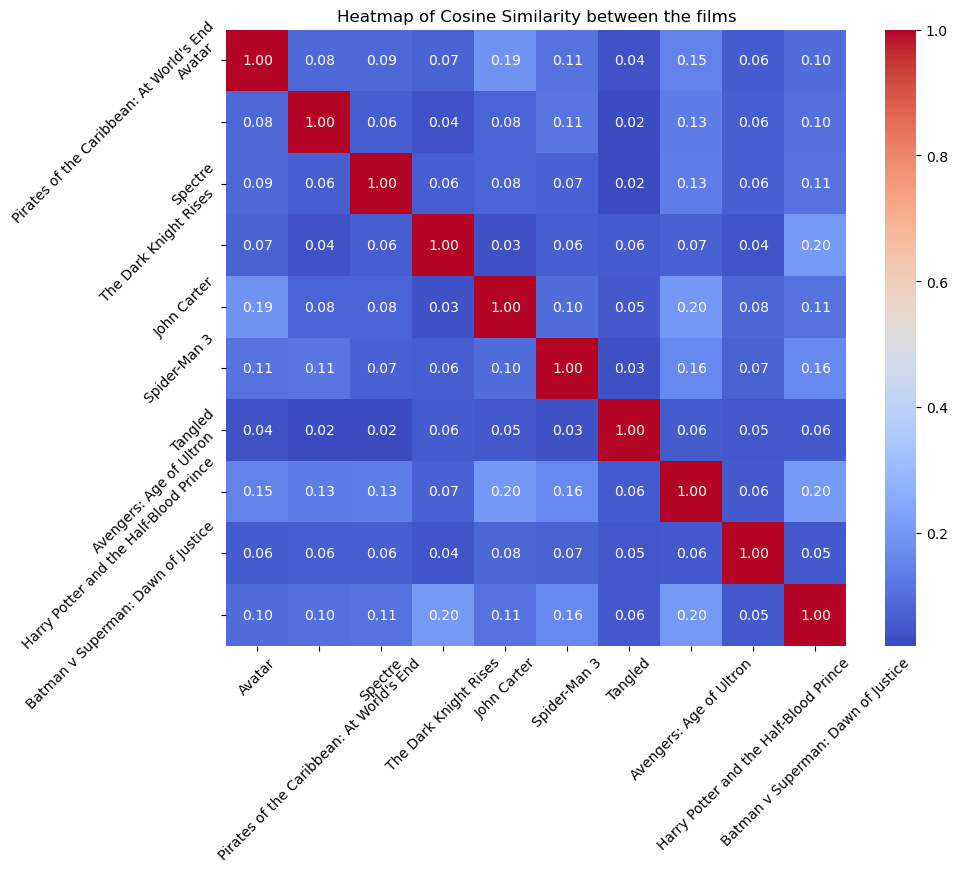

In [ ]:
num_movies = 10  
similarity_subset = similarity[:num_movies, :num_movies]

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_subset, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=new_df['title'][:num_movies], yticklabels=new_df['title'][:num_movies])
plt.title("Heatmap of Cosine Similarity between the films")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

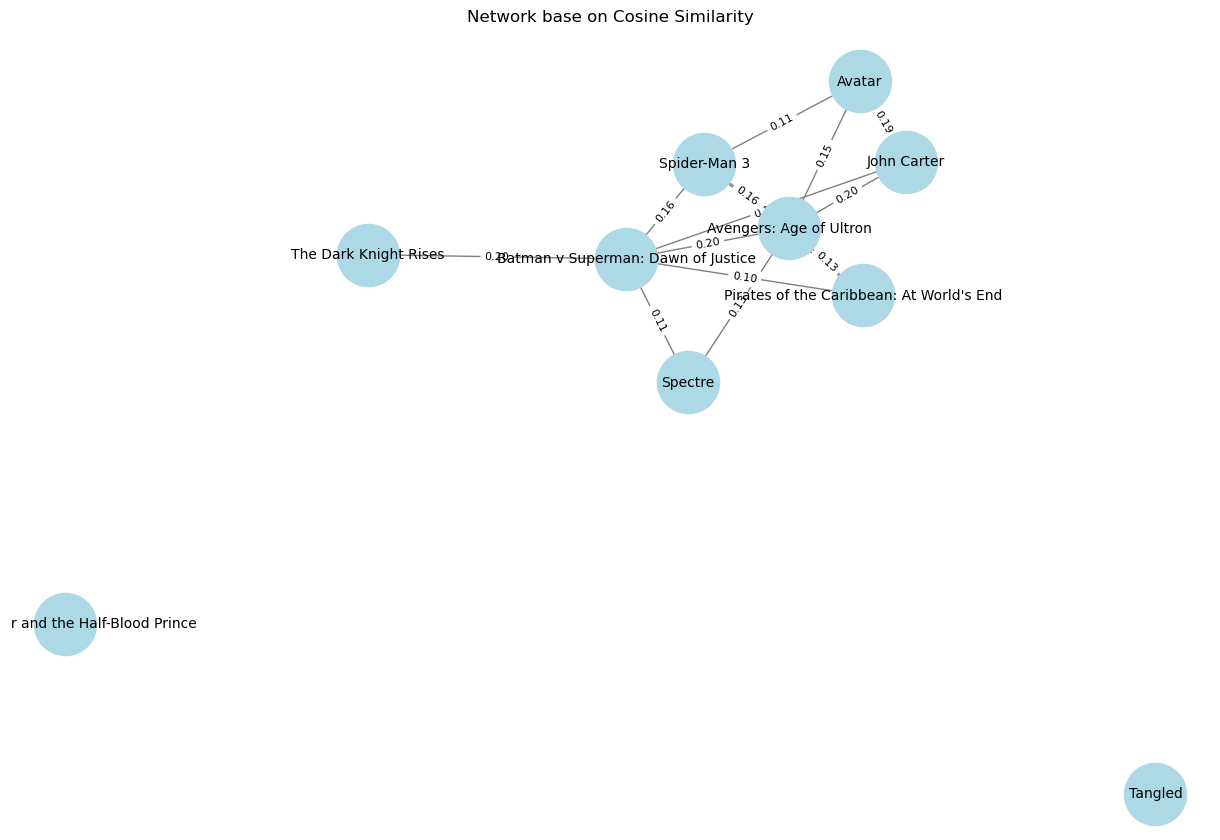

In [ ]:
num_movies = 10
G = nx.Graph()
movie_titles = new_df['title'][:num_movies].tolist()
G.add_nodes_from(movie_titles)

for i in range(num_movies):
    for j in range(i + 1, num_movies):
        if similarity[i, j] > 0.1:  
            G.add_edge(movie_titles[i], movie_titles[j], weight=similarity[i, j])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  
edges = G.edges(data=True)

nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in edges}, font_size=8)

plt.title("Network base on Cosine Similarity")
plt.show()

## Recomendation

In [ ]:
def recommend(movie):
    index = new_df[new_df['title'] == movie].index[0]
    dis = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])
    for i in dis[1:6]:
        print(new_df.iloc[i[0]].title)

In [227]:
recommend('Spider-Man 2')

Spider-Man 3
Spider-Man
The Amazing Spider-Man
Iron Man 2
Superman


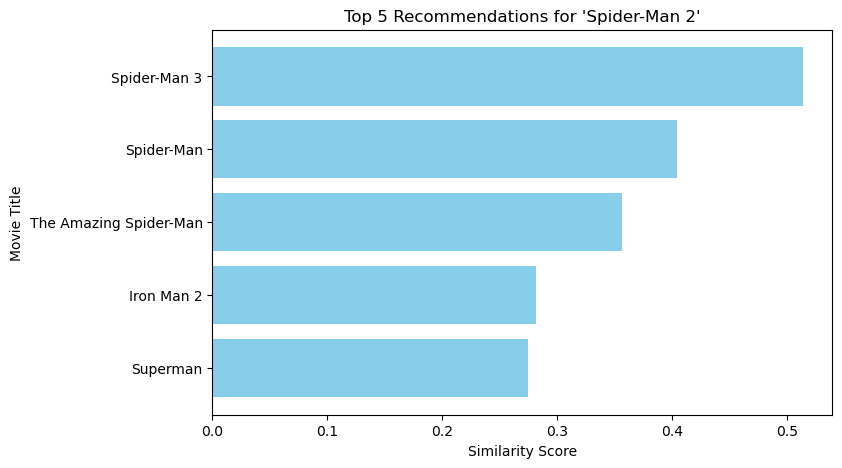

In [ ]:
def visualize_recommendations(movie):
    index = new_df[new_df['title'] == movie].index[0]
    dis = sorted(list(enumerate(similarity[index])), reverse=True, key=lambda x: x[1])[1:6]

    movie_names = [new_df.iloc[i[0]].title for i in dis]
    similarity_scores = [i[1] for i in dis]

    plt.figure(figsize=(8, 5))
    plt.barh(movie_names, similarity_scores, color='skyblue')
    plt.xlabel("Similarity Score")
    plt.ylabel("Movie Title")
    plt.title(f"Top 5 Recommendations for '{movie}'")
    plt.gca().invert_yaxis()  # Reverse order for better readability
    plt.show()

visualize_recommendations('Spider-Man 2')

### Export results

In [ ]:
import pickle
pickle.dump(new_df,open('pickle/movie_list.pkl','wb'))
pickle.dump(similarity,open('pickle/similarity.pkl','wb'))